In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

In [3]:
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
import astropy.constants as c

In [10]:
import sys
sys.path.append('../tools/')
from visual import rcparams_format

rcparams_format(mpl.rcParams)

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3',
    'deeppurple': '#984ea3',
    'deepblue': '#377eb8'
}

In [5]:
data = Table.read('galSpecExtra-dr8.fits')
data_tot = data[data['PLATEID'] > 0]
data_tot = data_tot[data_tot['LGM_TOT_P50'] > -9999]
data_tot = data_tot[data_tot['SPECSFR_TOT_P50'] > -9999]
data_tot = data_tot[data_tot['SFR_TOT_P50'] > -9999]
data_tot = data_tot[data_tot['LGM_FIB_P50'] > -9999]
data_tot = data_tot[data_tot['SPECSFR_FIB_P50'] > -9999]

In [6]:
bkg = data_tot[data_tot['BPTCLASS'] < 4]

In [7]:
import seaborn as sns

In [8]:
rcparams_format(mpl.rcParams)

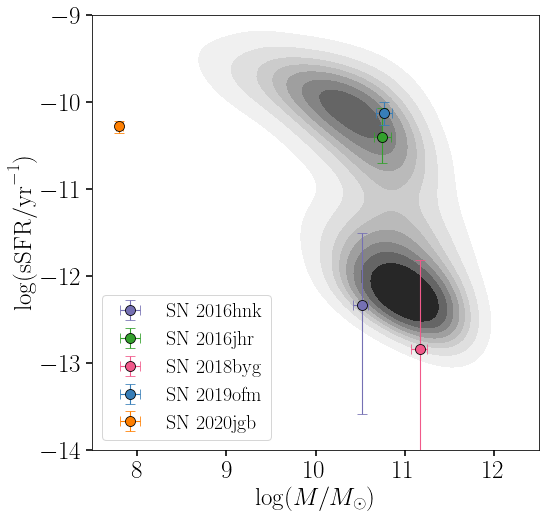

In [11]:
jgb = pd.read_csv('SN2020jgb_posteriors.csv')
byg = data_tot[data_tot['SPECOBJID'] == '1633681641756977152']
jhr = data_tot[data_tot['SPECOBJID'] == '324379878126282752 ']
ofm = data_tot[data_tot['SPECOBJID'] == '2411848919991478272']
hnk = data_tot[data_tot['SPECOBJID'] == '751129480658970624 ']

plt.figure(figsize=(8, 8))
ax = sns.kdeplot(x=np.array(data_tot['LGM_TOT_P50'][::100], dtype='f4'),
                 y=np.array(data_tot['SPECSFR_TOT_P50'][::100], dtype='f4'),
                 shade=True,
                 cmap="Greys",
                 levels=10)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
ax.set_xlabel(r'$\log(M/M_\odot)$')
ax.set_ylabel(r'$\log(\mathrm{sSFR/yr}^{-1})$')

targets = [hnk, jhr, byg, ofm]

cmap = ['purple', 'green', 'magenta', 'deepblue', 'orange']

labels = [
    '$\mathrm{SN\ 2016hnk}$', '$\mathrm{SN\ 2016jhr}$',
    '$\mathrm{SN\ 2018byg}$', '$\mathrm{SN\ 2019ofm}$',
    '$\mathrm{SN\ 2020jgb}$'
]

for k in range(len(targets) + 1):
    if k == 4:  #20jgb
        lgssfr = np.median(jgb['log(sSFR)'])
        lgssfr_l = [
            np.median(jgb['log(sSFR)']) - np.percentile(jgb['log(sSFR)'], 16)
        ]
        lgssfr_u = [
            np.percentile(jgb['log(sSFR)'], 84) - np.median(jgb['log(sSFR)'])
        ]
        lgmass = np.median(jgb['log(M/M_sol)'])
        lgmass_l = [np.median(jgb['log(M/M_sol)']) - np.percentile(jgb['log(M/M_sol)'], 16)]
        lgmass_u = [np.percentile(jgb['log(M/M_sol)'], 84) - np.median(jgb['log(M/M_sol)'])]
    else:
        lgmass = targets[k]['LGM_TOT_P50']
        lgmass_l = targets[k]['LGM_TOT_P50'] - targets[k]['LGM_TOT_P16']
        lgmass_u = targets[k]['LGM_TOT_P84'] - targets[k]['LGM_TOT_P50']
        lgssfr = targets[k]['SPECSFR_TOT_P50']
        lgssfr_l = targets[k]['SPECSFR_TOT_P50'] - targets[k][
            'SPECSFR_TOT_P16']
        lgssfr_u = targets[k]['SPECSFR_TOT_P84'] - targets[k][
            'SPECSFR_TOT_P50']

    plt.errorbar(
        lgmass,
        lgssfr,
        fmt='o',
        capsize=5,
        xerr=[lgmass_l, lgmass_u],
        yerr=[lgssfr_l, lgssfr_u],
        color=color_map[cmap[k]],
        label=labels[k],
        markersize=10,
        markeredgecolor='k',
        markeredgewidth=.8,
        #ecolor='k',
        elinewidth=1.1)

plt.legend(prop={'size': 20}, loc='lower left')
plt.xlim(7.5, 12.5)
plt.xticks([8, 9, 10, 11, 12])
plt.ylim(-14, -9)

#plt.savefig('../paper/host.pdf', bbox_inches='tight')
plt.show()

### SF MS for dwarfs 

> McGaugh+17

$$
\log\mathrm{(SFR)} = a+b\log (M_*)+\sigma,
$$
where
$$
a = −10.75\pm0.53,\quad b=1.04\pm0.06,\quad \sigma=0.34.
$$
Consequently,
$$
\log\mathrm{(sSFR)} = a+(b-1)\log (M_*)+\sigma,
$$

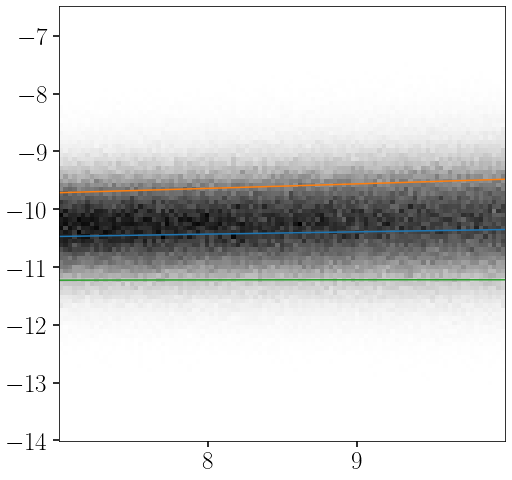

In [12]:
# a simple Monte Carlo simulation
l = 1000000
lg_M_dwarf = np.random.rand(l) * 3 + 7
mu_a, sigma_a = -10.75, 0.53
mu_b, sigma_b = 1.04, 0.06

a = np.random.randn(l) * sigma_a + mu_a
b = np.random.randn(l) * sigma_b + mu_b
sigma = 0.34

lg_sSFR = np.random.rand(l) * sigma + (a + (b - 1) * lg_M_dwarf)

lg_m = np.linspace(7, 10, 10)
sigma_y = (sigma_a**2 + sigma_b**2 * lg_m**2 + sigma**2)**.5
plt.figure(figsize=(8, 8))
plt.plot(lg_m, mu_a + (mu_b - 1) * lg_m)
plt.plot(lg_m, mu_a + (mu_b - 1) * lg_m + sigma_y)
plt.plot(lg_m, mu_a + (mu_b - 1) * lg_m - sigma_y)

plt.hist2d(lg_M_dwarf, lg_sSFR, bins=101, cmap='Greys')
plt.show()

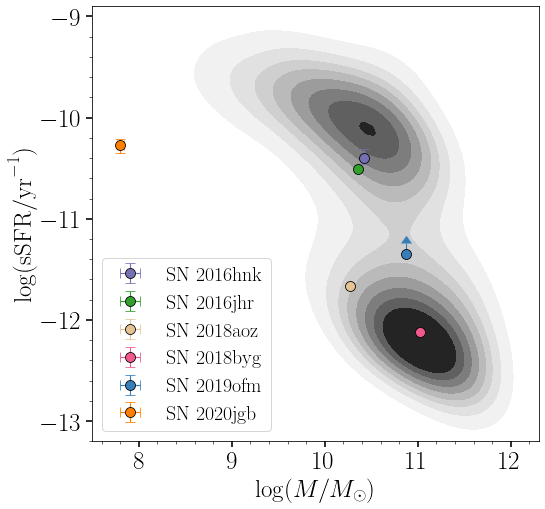

In [13]:
jgb = pd.read_csv('SN2020jgb_posteriors.csv')
byg = pd.read_csv('SN2018byg_old_posteriors.csv')
jhr = pd.read_csv('SN2016jhr_posteriors.csv')
ofm = pd.read_csv('SN2019ofm_posteriors.csv')
hnk = pd.read_csv('SN2016hnk_posteriors.csv')

plt.figure(figsize=(8, 8))
ax = sns.kdeplot(x=np.array(bkg['LGM_TOT_P50'][::100], dtype='f4'),
                 y=np.array(bkg['SPECSFR_TOT_P50'][::100], dtype='f4'),
                 shade=True,
                 cmap="Greys",
                 levels=10)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
ax.set_xlabel(r'$\log(M/M_\odot)$')
ax.set_ylabel(r'$\log(\mathrm{sSFR/yr}^{-1})$')

targets = [hnk, jhr, None, byg, ofm, jgb]

cmap = ['purple', 'green', 'brown', 'magenta', 'deepblue', 'orange']

labels = [
    '$\mathrm{SN\ 2016hnk}$', '$\mathrm{SN\ 2016jhr}$',
    '$\mathrm{SN\ 2018aoz}$', '$\mathrm{SN\ 2018byg}$',
    '$\mathrm{SN\ 2019ofm}$', '$\mathrm{SN\ 2020jgb}$'
]
for k in range(len(targets)):
    if k == 0:  #16hnk 
        ### Galbany+2019, IFS + STARLIGHT fit
        #sfr = 0.649
        #lgmass = 10.78
        #lgmass_u, lgmass_l = [0.12], [0.21]
        #mean_lgmass_u = (0.12 + 0.21) / 2
        #lgssfr_l = [((-np.log10(1 - 0.234 / sfr))**2 + mean_lgmass_u**2)**.5]
        #lgssfr_u = [(np.log10(1 + 0.234 / sfr)**2 + mean_lgmass_u**2)**.5]
        #lgssfr = np.log10(sfr) - lgmass

        ### Dong+2022, FUV-FIR photometry + prospector fit
        lgssfr = -10.40
        lgssfr_u, lgssfr_l = [0.09], [0.06]
        lgmass = 10.42
        lgmass_u, lgmass_l = [0.02], [0.02]
        
    elif k == 2:  #18aoz (CLU)
        sfr = 0.0408010001260029
        sfr_unc = 0.0017672008696269959
        mass = 18874589802.70777
        mass_unc = 382358172.79886824
        ssfr = sfr / mass
        ssfr_unc = ssfr * ((sfr_unc / sfr)**2 + (mass_unc / mass)**2)**.5
        lgmass_u, lgmass_l = [-np.log10(1 - mass_unc / mass)
                              ], [np.log10(1 - mass_unc / mass)]
        lgssfr_l = [-np.log10(1 - ssfr_unc / ssfr)]
        lgssfr_u = [np.log10(1 + ssfr_unc / ssfr)]
        lgmass = np.log10(mass)
        lgssfr = np.log10(ssfr)
    else:
        lgssfr = np.median(targets[k]['log(sSFR)'])
        lgssfr_l = [
            np.median(targets[k]['log(sSFR)']) -
            np.percentile(targets[k]['log(sSFR)'], 16)
        ]
        lgssfr_u = [
            np.percentile(targets[k]['log(sSFR)'], 84) -
            np.median(targets[k]['log(sSFR)'])
        ]
        lgmass = np.median(targets[k]['log(M/M_sol)'])
        lgmass_l = [
            np.median(targets[k]['log(M/M_sol)']) -
            np.percentile(targets[k]['log(M/M_sol)'], 16)
        ]
        lgmass_u = [
            np.percentile(targets[k]['log(M/M_sol)'], 84) -
            np.median(targets[k]['log(M/M_sol)'])
        ]
    #print('{:.2f}, {:.2f}'.format(lgssfr, lgmass))
    plt.errorbar(
        lgmass,
        lgssfr,
        fmt='o',
        capsize=5,
        xerr=[lgmass_l, lgmass_u],
        yerr=[lgssfr_l, np.array(lgssfr_u) + 0.1 * (k==4)],
        color=color_map[cmap[k]],
        label=labels[k],
        lolims=(k==4),
        markersize=10,
        markeredgecolor='k',
        markeredgewidth=.8,
        #ecolor='k',
        elinewidth=1.1)
        
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))

plt.legend(prop={'size': 20}, loc='lower left')
plt.xlim(7.5, 12.3)
plt.xticks([8, 9, 10, 11, 12])
plt.ylim(-13.2, -8.9)

plt.savefig('../paper/figures/host.pdf', bbox_inches='tight')
plt.show()

## SED fitting

In [14]:
import pandas as pd
from astropy.io import fits
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning

In [15]:
# PS1
g_lref = 4849.11  # * u.AA
r_lref = 6201.20  # * u.AA
i_lref = 7534.96  # * u.AA
z_lref = 8674.20  # * u.AA
y_lref = 9627.79  # * u.AA
PS_wv = np.array([g_lref, r_lref, i_lref, z_lref, y_lref])
bands = 'grizy'
Kron = ['{}FKronFlux'.format(band) for band in bands]
KronErr = ['{}FKronFluxErr'.format(band) for band in bands]
MeanKron = ['{}MeanKronMag'.format(band) for band in bands]
MeanKronErr = ['{}MeanKronMagErr'.format(band) for band in bands]

# Vista
J_lref = 12540.
K_lref = 21490.
J_Vega2AB = 0.916
K_Vega2AB = 1.827
Vista_wv = np.array([J_lref, K_lref])
Vista_Vega2AB = np.array([J_Vega2AB, K_Vega2AB])

# 2MASS
J_lref = 12350.
H_lref = 16620.
Ks_lref = 21590.
J_Vega2AB = 0.91
H_Vega2AB = 1.39
K_Vega2AB = 1.85
MASS_wv = np.array([J_lref, H_lref, K_lref])
MASS_Vega2AB = np.array([J_Vega2AB, H_Vega2AB, K_Vega2AB])

# WISE
W1_lref = 33526.
W1_Vega2AB = 2.699
W2_lref = 46028.
W2_Vega2AB = 3.339
W3_lref = 115608.
W3_Vega2AB = 5.174
W4_lref = 220883.
W4_Vega2AB = 6.620
WISE_wv = np.array([W1_lref, W2_lref])
WISE_Vega2AB = np.array([W1_Vega2AB, W2_Vega2AB])

# Legacy
LS_wv = np.array([g_lref, r_lref, z_lref, W1_lref, W2_lref, W3_lref, W4_lref])

### 16hnk

In [ ]:
z = 0.016268
ebv = 0.026
spec = fits.open('16hnk_sdss_spec.fits')
data = spec[1].data

wv = 10**data['loglam']
fl = data['flux']  # * 1e-17 in cgs
fl_unc = data['ivar']**-.5

Av = calALambda(wv, 3.1, ebv)

fl_jy = (fl * 1e-17 * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv * u.AA)) * 10**(0.4 * Av)
fl_unc_jy = (fl_unc * 1e-17 * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv * u.AA)) * 10**(0.4 * Av)
np.savetxt('16hnk_SDSS_corrected.ascii',
           np.array([wv, fl_jy, fl_unc_jy]).T,
           fmt='%.4f %.4e %.4e',
           header='Wavelength, Fnu (Jy), Uncertainty (Jy)')

In [ ]:
ifs = np.loadtxt('16hnk_IFS.ascii')

flag = np.where(ifs[:, 2] != 3)
wv_ifs = ifs[:, 0][flag] * (1 + z)
fl_ifs = ifs[:, 1][flag]  # in cgs
fl_unc_ifs = ifs[:, 2][flag]

Av = calALambda(wv_ifs, 3.1, ebv)

fl_jy_ifs = (fl_ifs * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv_ifs * u.AA)) * 10**(0.4 * Av)
fl_unc_jy_ifs = (fl_unc_ifs * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv_ifs * u.AA)) * 10**(0.4 * Av)
np.savetxt('16hnk_IFS_corrected.ascii',
           np.array([wv_ifs, fl_jy_ifs, fl_unc_jy_ifs]).T,
           fmt='%.4f %.4e %.4e',
           header='Wavelength, Fnu (Jy), Uncertainty (Jy)')

In [ ]:
ps = pd.read_csv('16hnk_PS.csv')
Av = calALambda(PS_wv, 3.1, ebv)
ps_fl = np.array(ps[Kron]).ravel() * 10**(0.4 * Av)
ps_fl_unc = np.array(ps[KronErr]).ravel() * 10**(0.4 * Av)
ps_mag = -2.5 * np.log10(ps_fl / 3631)
ps_mag_unc = 2.5 / 2 * np.log10((ps_fl + ps_fl_unc) / (ps_fl - ps_fl_unc))
for b in range(5):
    print('{:.3f} {:.3f}'.format(ps_mag[b], ps_mag_unc[b]))

In [ ]:
ls_mag = np.array([
    13.493575, 12.752737, 12.178795, 12.753428, 13.342093, 13.487814, 13.523232
])
ls_mag_unc = np.array([
    2.23962328e-04, 1.22956577e-04, 1.47929016e-04, 7.41716478e-04,
    1.73192985e-03, 1.81742408e-02, 1.23232964e-01
])
ls_fl = 3631 * 10**(-0.4 * ls_mag)
ls_fl_unc = (10**(0.4 * ls_mag_unc) - 10**(-0.4 * ls_mag_unc)) / 2 * ls_fl
print(ls_fl / ls_fl_unc)
for b in range(7):
    print('{:.5f} {:.5f}'.format(ls_mag[b], ls_mag_unc[b]))

In [ ]:
Av = calALambda(Vista_wv, 3.1, ebv)
vista_mag = np.array([11.9137, 10.8840]) - Av + Vista_Vega2AB
vista_mag_unc = np.array([0.0008, 0.0018])
vista_fl = 10**(-0.4 * vista_mag) * 3631
vista_fl_unc = (10**(0.4 * vista_mag_unc) -
               10**(-0.4 * vista_mag_unc)) / 2 * vista_fl
for b in range(2):
    print('{:.4f} {:.4f}'.format(vista_mag[b], vista_mag_unc[b]))

In [ ]:
Av = calALambda(WISE_wv, 3.1, ebv)

#WISE_mag = np.array([10.876, 10.978, 9.945, 8.262]) - Av + WISE_Vega2AB
#WISE_mag_unc = np.array([0.022, 0.020, 0.038, 0.184])

WISE_vega = np.array([3.5642e+04, 3.4364e+04])
WISE_vega_unc = np.array([3.0632e+01, 6.6203e+01])
WISE_mag = 22.5 - 2.5 * np.log10(WISE_vega) - Av + WISE_Vega2AB
WISE_mag_unc = 2.5 / 2 * np.log10(
    (WISE_vega + WISE_vega_unc) / (WISE_vega - WISE_vega_unc))
WISE_fl = 10**(-0.4 * WISE_mag) * 3631
WISE_fl_unc = (10**(0.4 * WISE_mag_unc) -
               10**(-0.4 * WISE_mag_unc)) / 2 * WISE_fl
print(22.5 - 2.5 * np.log10(WISE_vega))
for b in range(2):
    print('{:.4f} {:.4f}'.format(WISE_mag[b], WISE_mag_unc[b]))

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(wv, fl_jy * 1e6 * 9, color='k', linewidth=.5)
plt.plot(wv_ifs, fl_jy_ifs * 1e6, color='grey', linewidth=.5)
#plt.errorbar(PS_wv, ps_fl * 1e6, yerr=ps_fl_unc * 1e6, fmt='o', capsize=3)
plt.errorbar(LS_wv,
             ls_fl * 1e6,
             yerr=ls_fl_unc * 1e6,
             fmt='o',
             capsize=3)
#plt.errorbar(Vista_wv,
#             vista_fl * 1e6,
#             yerr=vista_fl_unc * 1e6,
#             fmt='o',
#             capsize=3)
#plt.errorbar(WISE_wv,
#             WISE_fl * 1e6,
#             yerr=WISE_fl_unc * 1e6,
#             fmt='o',
#             capsize=3)
plt.ylim(1.5e3, 1e5)
plt.xlim(3e3, 1e4)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
plt.ylabel(r'$\mathrm{Flux}\ [\mu\mathrm{Jy}]$')

### 16jhr

In [ ]:
z = 0.117368
ebv = 0.023
spec = fits.open('16jhr_sdss_spec.fits')
data = spec[1].data

wv = 10**data['loglam']
fl = data['flux']  # * 1e-17 in cgs
fl_unc = data['ivar']**-.5

Av = calALambda(wv, 3.1, ebv)

fl_jy = (fl * 1e-17 * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv * u.AA)) * 10**(0.4 * Av)
fl_unc_jy = (fl_unc * 1e-17 * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv * u.AA)) * 10**(0.4 * Av)
np.savetxt('16jhr_SDSS_corrected.ascii',
           np.array([wv, fl_jy, fl_unc_jy]).T,
           fmt='%.4f %.4e %.4e',
           header='Wavelength, Fnu (Jy), Uncertainty (Jy)')

In [ ]:
ps = pd.read_csv('16jhr_PS.csv')
Av = calALambda(PS_wv, 3.1, ebv)
ps_fl = np.array(ps[Kron]).ravel() * 10**(0.4 * Av)
ps_fl_unc = np.array(ps[KronErr]).ravel() * 10**(0.4 * Av)
ps_mag = -2.5 * np.log10(ps_fl / 3631)
ps_mag_unc = 2.5 / 2 * np.log10((ps_fl + ps_fl_unc) / (ps_fl - ps_fl_unc))
for b in range(5):
    print('{:.3f} {:.3f}'.format(ps_mag[b], ps_mag_unc[b]))

In [ ]:
ls_mag = np.array([
    18.167557, 17.363821, 16.732494, 16.792177, 17.23194, 15.36627, 14.075951
])
ls_mag_unc = np.array([
    0.0026484, 0.00152188, 0.0015603, 0.00574873, 0.01506325, 0.08391096,
    0.18814428
])
ls_fl = 3631 * 10**(-0.4 * ls_mag)
ls_fl_unc = (10**(0.4 * ls_mag_unc) - 10**(-0.4 * ls_mag_unc)) / 2 * ls_fl
print(ls_fl / ls_fl_unc)
for b in range(7):
    print('{:.5f} {:.5f}'.format(ls_mag[b], ls_mag_unc[b]))

In [ ]:
Av = calALambda(WISE_wv, 3.1, ebv)

#WISE_mag = np.array([14.261, 14.037, 10.622, 8.491]) - Av + WISE_Vega2AB
#WISE_mag_unc = np.array([0.030, 0.064, 0.115, 0.366])

WISE_vega = np.array([1.8232e+03, 2.3744e+03])
WISE_vega_unc = np.array([1.0707e+01, 3.6108e+01])
WISE_mag = 22.5 - 2.5 * np.log10(WISE_vega) - Av + WISE_Vega2AB
WISE_mag_unc = 2.5 / 2 * np.log10(
    (WISE_vega + WISE_vega_unc) / (WISE_vega - WISE_vega_unc))
WISE_fl = 10**(-0.4 * WISE_mag) * 3631
WISE_fl_unc = (10**(0.4 * WISE_mag_unc) -
               10**(-0.4 * WISE_mag_unc)) / 2 * WISE_fl
print(22.5 - 2.5 * np.log10(WISE_vega))
for b in range(2):
    print('{:.4f} {:.4f}'.format(WISE_mag[b], WISE_mag_unc[b]))

In [ ]:
'''Av = calALambda(MASS_wv, 3.1, ebv)
mass_mag = np.array([16.192, 15.420, 15.106]) - Av + MASS_Vega2AB
mass_mag_unc = np.array([0.134, 0.116, 0.179])
mass_fl = 10**(-0.4 * mass_mag) * 3631
mass_fl_unc = (10**(0.4 * mass_mag_unc) -
               10**(-0.4 * mass_mag_unc)) / 2 * mass_fl'''

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(wv, fl_jy * 1e6 * 2, color='k', linewidth=1)
#plt.errorbar(PS_wv, ps_fl * 1e6, yerr=ps_fl_unc * 1e6, fmt='o', capsize=3)
plt.errorbar(LS_wv,
             ls_fl * 1e6,
             yerr=ls_fl_unc * 1e6,
             fmt='o',
             capsize=3)
#plt.errorbar(WISE_wv,
#             WISE_fl * 1e6,
#             yerr=WISE_fl_unc * 1e6,
#             fmt='o',
#             capsize=3)
plt.xscale('log')
plt.yscale('log')
plt.ylim(4e1, 1.1e4)
plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
plt.ylabel(r'$\mathrm{Flux}\ [\mu\mathrm{Jy}]$')

### 18byg

In [ ]:
z = 0.06633826
ebv = 0.008
spec = fits.open('18byg_sdss_spec.fits')
data = spec[1].data

wv = 10**data['loglam']
fl = data['flux']  # * 1e-17 in cgs
fl_unc = data['ivar']**-.5

Av = calALambda(wv, 3.1, ebv)

fl_jy = (fl * 1e-17 * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv * u.AA)) * 10**(0.4 * Av)
fl_unc_jy = (fl_unc * 1e-17 * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv * u.AA)) * 10**(0.4 * Av)
np.savetxt('18byg_SDSS_corrected.ascii',
           np.array([wv, fl_jy, fl_unc_jy]).T,
           fmt='%.4f %.4e %.4e',
           header='Wavelength, Fnu (Jy), Uncertainty (Jy)')

In [ ]:
ps = pd.read_csv('18byg_PS.csv')
Av = calALambda(PS_wv, 3.1, ebv)
ps_fl = np.array(ps[Kron]).ravel() * 10**(0.4 * Av)
ps_fl_unc = np.array(ps[KronErr]).ravel() * 10**(0.4 * Av)
ps_mag = -2.5 * np.log10(ps_fl / 3631)
ps_mag_unc = 2.5 / 2 * np.log10((ps_fl + ps_fl_unc) / (ps_fl - ps_fl_unc))
for b in range(5):
    print('{:.3f} {:.3f}'.format(ps_mag[b], ps_mag_unc[b]))

In [ ]:
ls_mag = np.array(
    [16.133438, 15.205797, 14.563972, 14.799189, 15.386065, 16.641302, np.nan])
ls_mag_unc = np.array([
    1.41691785e-03, 9.66420738e-04, 5.55811186e-04, 1.78167150e-03,
    4.09284384e-03, 1.75035459e-01, np.nan
])

ls_fl = 3631 * 10**(-0.4 * ls_mag)
ls_fl_unc = (10**(0.4 * ls_mag_unc) - 10**(-0.4 * ls_mag_unc)) / 2 * ls_fl
print(ls_fl / ls_fl_unc)
for b in range(7):
    print('{:.5f} {:.5f}'.format(ls_mag[b], ls_mag_unc[b]))

In [ ]:
Av = calALambda(WISE_wv, 3.1, ebv)
#WISE_mag = np.array([12.443, 12.433, 10.834, 8.190]) - Av + WISE_Vega2AB
#WISE_mag_unc = np.array([0.024, 0.024, 0.072, 0.166])

WISE_vega = np.array([1.0154e+04, 1.0517e+04])
WISE_vega_unc = np.array([1.7043e+01, 4.0797e+01])
WISE_mag = 22.5 - 2.5 * np.log10(WISE_vega) - Av + WISE_Vega2AB
WISE_mag_unc = 2.5 / 2 * np.log10(
    (WISE_vega + WISE_vega_unc) / (WISE_vega - WISE_vega_unc))
WISE_fl = 10**(-0.4 * WISE_mag) * 3631
WISE_fl_unc = (10**(0.4 * WISE_mag_unc) -
               10**(-0.4 * WISE_mag_unc)) / 2 * WISE_fl
print(22.5 - 2.5 * np.log10(WISE_vega))
for b in range(2):
    print('{:.4f} {:.4f}'.format(WISE_mag[b], WISE_mag_unc[b]))

In [ ]:
Av = calALambda(MASS_wv, 3.1, ebv)
mass_mag = np.array([13.592, 12.802, 12.577]) - Av + MASS_Vega2AB  # Kron
mass_mag_unc = np.array([0.041, 0.054, 0.065])  # Kron
#mass_mag = np.array([14.333,13.722,13.323]) - Av + MASS_Vega2AB # point source
#mass_mag_unc = np.array([0.062,0.082,0.065]) # point source
mass_fl = 10**(-0.4 * mass_mag) * 3631
mass_fl_unc = (10**(0.4 * mass_mag_unc) -
               10**(-0.4 * mass_mag_unc)) / 2 * mass_fl
for b in range(2):
    print('{:.3f} {:.3f}'.format(mass_mag[b], mass_mag_unc[b]))

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(wv, fl_jy * 1e6 * 3.5, color='k', linewidth=1)
#plt.errorbar(PS_wv, ps_fl * 1e6, yerr=ps_fl_unc * 1e6, fmt='o', capsize=3, label='Forced Kron')
plt.errorbar(LS_wv,
             ls_fl * 1e6,
             yerr=ls_fl_unc * 1e6,
             fmt='o',
             capsize=3, label='LS')
#plt.errorbar(MASS_wv,
#             mass_fl * 1e6,
#             yerr=mass_fl_unc * 1e6,
#             fmt='o',
#             capsize=3)
#plt.errorbar(WISE_wv,
#             WISE_fl * 1e6,
#             yerr=WISE_fl_unc * 1e6,
#             fmt='o',
#             capsize=3)
plt.ylim(3e2, 1e4)
#plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
plt.ylabel(r'$\mathrm{Flux}\ [\mu\mathrm{Jy}]$')

### 19ofm

In [ ]:
z = 0.030254
ebv = 0.025
spec = fits.open('19ofm_sdss_spec.fits')
data = spec[1].data

wv = 10**data['loglam']
fl = data['flux']  # * 1e-17 in cgs
fl_unc = data['ivar']**-.5

Av = calALambda(wv, 3.1, ebv)

fl_jy = (fl * 1e-17 * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv * u.AA)) * 10**(0.4 * Av)
fl_unc_jy = (fl_unc * 1e-17 * u.erg / u.s / u.cm**2 / u.AA).to(
    'Jy', u.spectral_density(wv * u.AA)) * 10**(0.4 * Av)
np.savetxt('19ofm_SDSS_corrected.ascii',
           np.array([wv, fl_jy, fl_unc_jy]).T,
           fmt='%.4f %.4e %.4e',
           header='Wavelength, Fnu (Jy), Uncertainty (Jy)')

In [ ]:
ps = pd.read_csv('19ofm_PS.csv')
Av = calALambda(PS_wv, 3.1, ebv)
ps_fl = np.array(ps[Kron]).ravel() * 10**(0.4 * Av)
ps_fl_unc = np.array(ps[KronErr]).ravel() * 10**(0.4 * Av)
ps_mag = -2.5 * np.log10(ps_fl / 3631)
ps_mag_unc = 2.5 / 2 * np.log10((ps_fl + ps_fl_unc) / (ps_fl - ps_fl_unc))
for b in range(5):
    print('{:.3f} {:.3f}'.format(ps_mag[b], ps_mag_unc[b]))

In [ ]:
ls_mag = np.array([
    14.62047, 13.833223, 13.243655, 13.579782, 14.026214, 13.070807, 12.548615
])
WISE_W1
0.015
13.732
WISE_W2
0.016
14.273
ls_mag_unc = np.array([
    0.00052933, 0.00039882, 0.00029072, 0.00105018, 0.00224105, 0.00843635,
    0.03585354
])

ls_fl = 3631 * 10**(-0.4 * ls_mag)
ls_fl_unc = (10**(0.4 * ls_mag_unc) - 10**(-0.4 * ls_mag_unc)) / 2 * ls_fl
print(ls_fl / ls_fl_unc)
for b in range(7):
    print('{:.5f} {:.5f}'.format(ls_mag[b], ls_mag_unc[b]))

In [ ]:
Av = calALambda(WISE_wv, 3.1, ebv)
#WISE_mag = np.array([11.695,11.321,8.987,6.996]) - Av + WISE_Vega2AB
#WISE_mag_unc = np.array([0.022,0.020,0.021,0.061])

WISE_vega = np.array([1.7196e+04, 2.1312e+04])
WISE_vega_unc = np.array([2.1392e+01, 5.2667e+01])
WISE_mag = 22.5 - 2.5 * np.log10(WISE_vega) - Av + WISE_Vega2AB
WISE_mag_unc = 2.5 / 2 * np.log10(
    (WISE_vega + WISE_vega_unc) / (WISE_vega - WISE_vega_unc))
WISE_fl = 10**(-0.4 * WISE_mag) * 3631
WISE_fl_unc = (10**(0.4 * WISE_mag_unc) -
               10**(-0.4 * WISE_mag_unc)) / 2 * WISE_fl
print(22.5 - 2.5 * np.log10(WISE_vega))
for b in range(2):
    print('{:.4f} {:.4f}'.format(WISE_mag[b], WISE_mag_unc[b]))

In [ ]:
Av = calALambda(MASS_wv, 3.1, ebv)
mass_mag = np.array([12.423,11.741,11.494]) - Av + MASS_Vega2AB # extended source, Kron
mass_mag_unc = np.array([0.039,0.049,0.075]) #extended source, Kron
#mass_mag = np.array([13.935,13.104,12.828]) - Av + MASS_Vega2AB # point source
#mass_mag_unc = np.array([0.055,0.058,0.051]) # point source
mass_fl = 10**(-0.4 * mass_mag) * 3631
mass_fl_unc = (10**(0.4 * mass_mag_unc) -
               10**(-0.4 * mass_mag_unc)) / 2 * mass_fl
for b in range(2):
    print('{:.3f} {:.3f}'.format(mass_mag[b], mass_mag_unc[b]))

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(wv, fl_jy * 1e6 * 8.5, color='k', linewidth=1)
#plt.errorbar(PS_wv, ps_fl * 1e6, yerr=ps_fl_unc * 1e6, fmt='o', capsize=3)
plt.errorbar(LS_wv,
             ls_fl * 1e6,
             yerr=ls_fl_unc * 1e6,
             fmt='o',
             capsize=3)
#plt.errorbar(MASS_wv,
#             mass_fl * 1e6,
#             yerr=mass_fl_unc * 1e6,
#             fmt='o',
#             capsize=3)
#plt.errorbar(WISE_wv,
#             WISE_fl * 1e6,
#             yerr=WISE_fl_unc * 1e6,
#             fmt='o',
#             capsize=3)
plt.ylim(1e3, 4e4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda\ [\mathrm{\mathring{A}}]$')
plt.ylabel(r'$\mathrm{Flux}\ [\mu\mathrm{Jy}]$')